# Embedding Generation Notebook

## Objective
This notebook demonstrates how to use custom encoder models to generate embeddings from the MNIST dataset. These models are implemented in `encoder_models.py`, and the training processes are defined in `encoder_training.py`.

## Workflow
1. **Load and Preprocess Data**:
   - Load the MNIST dataset for testing the embedding generation process.
   - Normalize and prepare the data.
2. **Model Selection and Training**:
   - Train selected encoder models from `encoder_models.py`.
   - Generate embeddings from the bottleneck layer.
3. **Feature Extraction**:
   - Generate embeddings using matrix factorization (PCA, SVD, NMF) and SIFT.
4. **Save Embeddings**:
   - Save all embeddings and trained models for reuse.

## Models and Methods
### Supported Models
The following encoder models are available for training and embedding generation. Each model is implemented in `encoder_models.py`:
- **Encoder Models**:
  - BasicAutoencoder, IntermediateAutoencoder, AdvancedAutoencoder, EnhancedAutoencoder.
  - BasicVAE, VAEWithFCDecoder, ImprovedVAE, FlexibleVAE.
- **Feature Extraction**:
  - PCA, SVD, NMF.
  - SIFT, Kernel PCA.

#### **Autoencoders**
1. **BasicAutoencoder**:
   - A simple autoencoder with:
     - **Encoder**: Two convolutional layers followed by max-pooling.
     - **Decoder**: Two transposed convolutional layers to reconstruct the input.
   - Designed for grayscale datasets like MNIST.
   - Suitable for basic dimensionality reduction and reconstruction tasks.

2. **IntermediateAutoencoder**:
   - A deeper autoencoder with:
     - **Batch Normalization** for improved stability.
     - Additional feature maps for a more expressive latent space.
   - Designed for moderately complex embedding tasks requiring better feature extraction.

3. **AdvancedAutoencoder**:
   - A sophisticated autoencoder with:
     - **Skip Connections** to improve gradient flow and reconstruction accuracy.
     - **LeakyReLU Activations** and Batch Normalization for robust performance.
   - Suitable for high-dimensional or structured data requiring detailed reconstruction.

4. **EnhancedAutoencoder**:
   - A deeper autoencoder with:
     - Additional convolutional layers in the encoder.
     - Transposed convolutional layers in the decoder.
     - LeakyReLU activations and Batch Normalization for better embedding representation.
   - Designed for datasets requiring intricate reconstructions under noisy conditions.

#### **Variational Autoencoders (VAEs)**
5. **BasicVAE**:
   - A simple VAE with:
     - **Encoder**: Two convolutional layers and a fully connected layer to parameterize the latent space.
     - **Decoder**: Fully connected and transposed convolution layers to reconstruct input images.
   - Suitable for generative tasks with simple latent spaces.

6. **VAEWithFCDecoder**:
   - A VAE with a fully connected decoder for enhanced latent-to-feature mapping.
   - Features:
     - **Encoder**: Convolutional layers with Batch Normalization.
     - **Decoder**: A combination of fully connected and transposed convolutional layers.

7. **ImprovedVAE**:
   - An advanced VAE with:
     - A bottleneck layer for enhanced feature extraction.
     - Transposed convolutions for smooth reconstructions.
     - KL divergence loss for latent space regularization.
   - Designed for datasets requiring expressive latent representations.

8. **FlexibleVAE**:
   - A flexible VAE that supports dynamic input shapes and optional projection heads for contrastive learning.
   - Suitable for embedding tasks with varying input dimensions.

9. **ImprovedFlexibleVAE**:
   - Combines convolutional and fully connected layers in the encoder.
   - Uses transposed convolutions in the decoder for better reconstruction.
   - Optional **Projection Head** for self-supervised contrastive learning tasks.

#### **Denoising Autoencoders**
10. **DenoisingAutoencoder**:
    - A denoising autoencoder with:
      - **Encoder**: Convolutional layers for feature extraction.
      - **Decoder**: Transposed convolutional layers for reconstruction.
      - Optional **Projection Head** for contrastive learning.
    - Supports two architectures:
      - **Basic**: Simpler structure for standard denoising tasks.
      - **Strong**: Deeper architecture for challenging noisy datasets.

#### **Feature Extraction and Normalizing Flow Models**
11. **Matrix Factorization**:
    - Embeddings generated using PCA, SVD, and NMF.
    - Useful for dimensionality reduction and compact representations.

12. **SIFT (Scale-Invariant Feature Transform)**:
    - Extracts scale-invariant features from images.
    - Pads feature descriptors to ensure consistent dimensionality.

13. **Kernel PCA**:
    - Nonlinear dimensionality reduction using Kernel PCA with adjustable kernels.

14. **Normalizing Flow Models**:
    - Transforms embeddings into a latent space using invertible transformations.
    - Useful for embedding refinement and generative tasks.


**Training**:
   - Each model is trained using the corresponding training loop defined in `encoder_training.py`.
   - Training includes support for reconstruction loss, KL divergence (for VAE), and optional noise injection.
**Embedding Generation**:
   - Once the models are trained, embeddings are generated for the MNIST dataset.
   - Encodings from the bottleneck layer are extracted for downstream tasks.
**Results Storage**:
   - Save trained models to `.pth` files.
   - Save generated embeddings to `.pt` files for reuse in downstream applications.

## Supported Features
- **Flexible Model Selection**:
  - Choose specific models to train and generate embeddings for, bypassing others if needed.
- **Custom Configuration**:
  - Easily modify parameters like the bottleneck size (`code_dim`), number of training epochs, and learning rates.

## Outputs
- Trained models saved as `.pth` files.
- Generated embeddings saved as `.pt` files in a structured directory (`./embeddings`).

## Notes
This notebook is designed for flexibility and reusability. You can:
- Add new encoder models in `encoder_models.py`.
- Customize training loops in `encoder_training.py`.
- Modify this notebook to train specific models or generate embeddings for specific datasets.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Mount Google Drive and set repository path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Repository path (adjust if needed)
repo_path = "/content/drive/MyDrive/GAN-thesis-project"

# Add repository path to sys.path for module imports
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Change working directory to the repository
os.chdir(repo_path)

# Verify the working directory
print(f"Current working directory: {os.getcwd()}")

# Configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/GAN-thesis-project
Using device: cuda


In [2]:
import inspect

# Import the entire modules
import src.data_utils as data_utils
import src.cl_loss_function as cl_loss
import src.losses as losses
import src.embeddings.encoder_models as encoder_models
import src.embeddings.encoder_training as encoder_training

# Function to list functions and classes in a module
def list_functions_and_classes(module):
    members = inspect.getmembers(module)
    functions = [name for name, obj in members if inspect.isfunction(obj)]
    classes = [name for name, obj in members if inspect.isclass(obj)]
    return functions, classes

# Function to print functions and classes in a readable format
def print_functions_and_classes(module_name, module):
    functions, classes = list_functions_and_classes(module)
    print(f"Module: {module_name}")
    print("  Functions:")
    for func in functions:
        print(f"    - {func}")
    print("  Classes:")
    for cls in classes:
        print(f"    - {cls}")
    print()  # Add a blank line for separation

# Print functions and classes for each module
print_functions_and_classes("src.data_utils", data_utils)
print_functions_and_classes("src.cl_loss_function", cl_loss)
print_functions_and_classes("src.losses", losses)
print_functions_and_classes("src.embeddings.encoder_models", encoder_models)
print_functions_and_classes("src.embeddings.encoder_training", encoder_training)

Module: src.data_utils
  Functions:
    - analyze_embeddings
    - analyze_embeddings_v2
    - create_dataloader
    - create_embedding_loaders
    - generate_embeddings
    - kurtosis
    - load_data
    - load_embeddings
    - load_mnist_data
    - pdist
    - preprocess_images
    - save_embeddings
    - skew
    - split_dataset
    - train_test_split
    - visualize_embeddings
  Classes:
    - DataLoader
    - LocalOutlierFactor
    - TensorDataset

Module: src.cl_loss_function
  Functions:
    - augment
    - compute_nt_xent_loss_with_augmentation
    - compute_triplet_loss_with_augmentation
    - contrastive_loss
    - hflip
    - info_nce_loss
    - resize
  Classes:
    - BYOLLoss
    - BarlowTwinsLoss
    - ContrastiveHead
    - DataLoader
    - NTXentLoss
    - PCA
    - Predictor
    - TensorDataset
    - TripletLoss
    - VicRegLoss

Module: src.losses
  Functions:
    - add_noise
    - cyclical_beta_schedule
    - linear_beta_schedule
    - loss_function_dae_ssim
    - vae

Sampled Dataset: (700, 1, 28, 28) (700,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


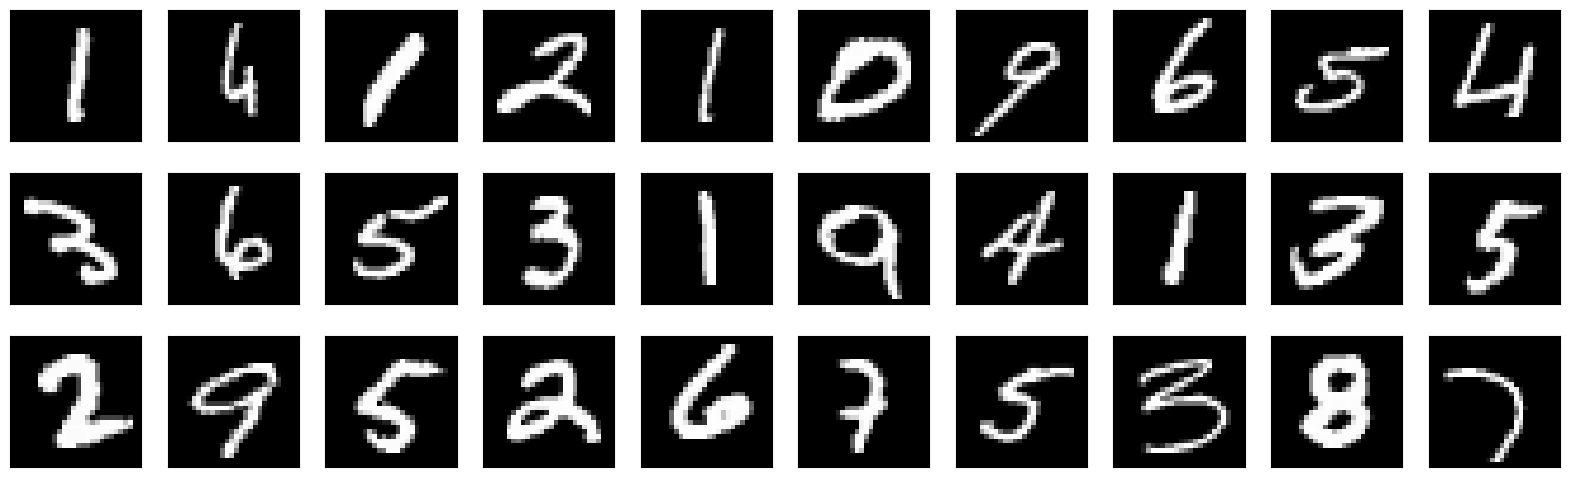

In [ ]:
# Load and Preprocess MNIST Data
fraction = 0.01  # Fraction of the dataset to use
batch_size = 64

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = data_utils.load_mnist_data(fraction=fraction, batch_size=batch_size, shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 30
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
#     model.eval()  # Set model to evaluation mode
#     embeddings = []
#     labels = []

#     with torch.no_grad():
#         for images, label_batch in data_loader:
#             images = images.to(device)
#             if embedding_type == "autoencoder":
#                 encoded, _ = model(images)
#             elif embedding_type == "vae":
#                 mu, _, _ = model(images)
#                 encoded = mu  # Use the mean of the latent space
#             elif embedding_type == "dae":
#                 _, _, encoded = model(images)
#             else:
#                 raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

#             embeddings.append(encoded.cpu())
#             labels.append(label_batch)

#     embeddings = torch.cat(embeddings, dim=0)
#     labels = torch.cat(labels, dim=0)

#     return embeddings, labels

In [ ]:
# import torch.nn.functional as F

# class NTXentLoss(nn.Module):
#     def __init__(self, temperature=0.5):
#         super(NTXentLoss, self).__init__()
#         self.temperature = temperature

#     def forward(self, z_i, z_j):
#         batch_size = z_i.size(0)

#         # Flatten the input tensors if they are not already 2D
#         z_i = z_i.view(z_i.size(0), -1)  # Shape: (batch_size, embedding_dim)
#         z_j = z_j.view(z_j.size(0), -1)  # Shape: (batch_size, embedding_dim)

#         # Normalize the embeddings
#         z_i = F.normalize(z_i, dim=1)
#         z_j = F.normalize(z_j, dim=1)

#         # Concatenate the embeddings
#         z = torch.cat([z_i, z_j], dim=0)  # Shape: (2 * batch_size, embedding_dim)

#         # Compute the similarity matrix
#         similarity_matrix = torch.matmul(z, z.T) / self.temperature  # Shape: (2 * batch_size, 2 * batch_size)

#         # Mask for positives and negatives
#         mask = ~torch.eye(2 * batch_size, device=z.device).bool()
#         positives = torch.cat([
#             torch.diag(similarity_matrix, batch_size),  # Positive pairs (z_i, z_j)
#             torch.diag(similarity_matrix, -batch_size)  # Positive pairs (z_j, z_i)
#         ])
#         negatives = similarity_matrix.masked_select(mask).view(2 * batch_size, -1)

#         # Compute the NT-Xent loss
#         numerator = torch.exp(positives)
#         denominator = torch.sum(torch.exp(negatives), dim=-1)
#         loss = -torch.mean(torch.log(numerator / denominator))

#         return loss

# class VicRegLoss(nn.Module):
#     def __init__(self, lambda_var=25, mu_mean=25, nu_cov=1):
#         super(VicRegLoss, self).__init__()
#         self.lambda_var = lambda_var
#         self.mu_mean = mu_mean
#         self.nu_cov = nu_cov

#     def forward(self, z1, z2):
#         # Flatten z1 and z2 if they are 4D
#         if z1.dim() == 4:
#             z1 = z1.view(z1.size(0), -1)  # Shape: (batch_size, 1 * 28 * 28)
#         if z2.dim() == 4:
#             z2 = z2.view(z2.size(0), -1)  # Shape: (batch_size, 1 * 28 * 28)

#         # Variance loss
#         variance_loss = torch.mean(torch.relu(1 - torch.std(z1, dim=0))) + \
#                         torch.mean(torch.relu(1 - torch.std(z2, dim=0)))

#         # Mean loss
#         mean_loss = torch.mean((torch.mean(z1, dim=0) - torch.mean(z2, dim=0))**2)

#         # Covariance loss
#         z1_centered = z1 - z1.mean(dim=0)
#         z2_centered = z2 - z2.mean(dim=0)

#         covariance_matrix_z1 = torch.mm(z1_centered.T, z1_centered) / (z1.size(0) - 1)
#         covariance_matrix_z2 = torch.mm(z2_centered.T, z2_centered) / (z2.size(0) - 1)

#         covariance_loss = torch.sum(covariance_matrix_z1 ** 2) - torch.sum(torch.diag(covariance_matrix_z1) ** 2) + \
#                           torch.sum(covariance_matrix_z2 ** 2) - torch.sum(torch.diag(covariance_matrix_z2) ** 2)

#         # Total loss
#         total_loss = self.lambda_var * variance_loss + \
#                      self.mu_mean * mean_loss + \
#                      self.nu_cov * covariance_loss
#         return total_loss

# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin
#         self.criterion = nn.TripletMarginWithDistanceLoss(
#             distance_function=lambda a, b: 1.0 - F.cosine_similarity(a, b),
#             margin=self.margin
#         )

#     def forward(self, anchor, positive, negative):
#         return self.criterion(anchor, positive, negative)

# class BarlowTwinsLoss(nn.Module):
#     def __init__(self, lambda_param=5e-3):
#         super(BarlowTwinsLoss, self).__init__()
#         self.lambda_param = lambda_param

#     def forward(self, z_a, z_b):
#         """
#         Compute the Barlow Twins loss between two sets of embeddings.

#         Args:
#             z_a (torch.Tensor): First set of embeddings.
#             z_b (torch.Tensor): Second set of embeddings.

#         Returns:
#             torch.Tensor: Computed Barlow Twins loss.
#         """
#         batch_size = z_a.size(0)
#         feature_dim = z_a.size(1)

#         # Normalize embeddings
#         z_a = (z_a - z_a.mean(dim=0)) / z_a.std(dim=0)
#         z_b = (z_b - z_b.mean(dim=0)) / z_b.std(dim=0)

#         # Compute cross-correlation matrix
#         cross_corr = torch.matmul(z_a.T, z_b) / batch_size

#         # Loss terms
#         invariance_loss = torch.sum((1 - torch.diag(cross_corr)) ** 2)
#         redundancy_loss = torch.sum(torch.triu(cross_corr, diagonal=1) ** 2) + torch.sum(torch.tril(cross_corr, diagonal=-1) ** 2)

#         # Total loss
#         loss = invariance_loss + self.lambda_param * redundancy_loss
#         return loss

class BYOLLoss(nn.Module):
    def __init__(self):
        super(BYOLLoss, self).__init__()

    def forward(self, z_a, z_b, predictor):
        """
        Compute the BYOL loss between two sets of embeddings.

        Args:
            z_a (torch.Tensor): First set of embeddings.
            z_b (torch.Tensor): Second set of embeddings.
            predictor (nn.Module): Predictor network.

        Returns:
            torch.Tensor: Computed BYOL loss.
        """
        # Normalize embeddings
        z_a = F.normalize(z_a, dim=1)
        z_b = F.normalize(z_b, dim=1)

        # Predict z_b from z_a
        p_a = predictor(z_a)
        p_a = F.normalize(p_a, dim=1)

        # Compute MSE loss between predicted and target embeddings
        loss = 2 - 2 * (p_a * z_b).sum(dim=1).mean()
        return loss

# class Predictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim=512, output_dim=50):
#         super(Predictor, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, output_dim),
#         )

#     def forward(self, x):
#         return self.net(x)

In [ ]:
import inspect

def train_autoencoder_v4(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    device: str = "cpu",
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    contrastive_loss_fn: Optional[Callable] = None,
    temperature: float = 0.5,
    triplet_data: bool = False,
    augment_fn: Optional[Callable] = None,
    predictor: Optional[nn.Module] = None,  # Add predictor for BYOL
    patience: int = 5,
    min_delta: float = 0.001,
):
    """
    Unified training function for autoencoders with support for:
    - Reconstruction loss
    - Contrastive loss (e.g., NT-Xent, VicReg, Triplet, Contrastive, InfoNCE, Barlow Twins, BYOL)
    - Noise injection (for denoising autoencoders)
    - Data augmentation
    - Early stopping
    """
    model.to(device).train()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)

                    # Flatten embeddings
                    encoded = encoded.view(encoded.size(0), -1)
                    positive_encoded = positive_encoded.view(positive_encoded.size(0), -1)
                    negative_encoded = negative_encoded.view(negative_encoded.size(0), -1)

                    # Compute triplet loss
                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent, VicReg, Contrastive, InfoNCE, Barlow Twins, BYOL, or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation

                    # Flatten embeddings
                    z1 = z1.view(z1.size(0), -1)
                    z2 = z2.view(z2.size(0), -1)

                    # Handle all contrastive losses uniformly
                    if isinstance(contrastive_loss_fn, BYOLLoss):
                        # BYOL requires a predictor
                        if predictor is None:
                            raise ValueError("Predictor network must be provided for BYOL loss.")
                        contrastive_loss_value = contrastive_loss_fn(z1, z2, predictor)
                    else:
                        # # Check if the loss function accepts a `temperature` parameter
                        # if "temperature" in inspect.signature(contrastive_loss_fn.forward).parameters:
                        #     contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature=temperature)
                        # else:
                        #     contrastive_loss_value = contrastive_loss_fn(z1, z2)
                        # Check if the loss function accepts a `temperature` parameter
                        if "temperature" in inspect.signature(contrastive_loss_fn).parameters:
                            contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature=temperature)
                        else:
                            contrastive_loss_value = contrastive_loss_fn(z1, z2)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Compute average epoch loss
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}")

        # Check for early stopping
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

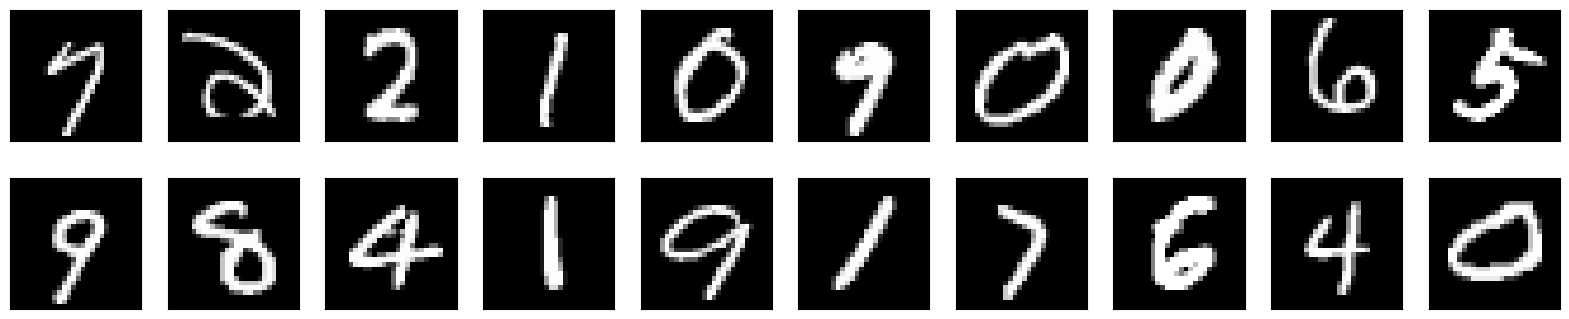

Training IntermediateAutoencoder with info_nce loss...
Epoch [1/50], Train Loss: 4.3815
Epoch [2/50], Train Loss: 4.2643
Epoch [3/50], Train Loss: 4.2422
Epoch [4/50], Train Loss: 4.2292
Epoch [5/50], Train Loss: 4.2260
Epoch [6/50], Train Loss: 4.2212
Epoch [7/50], Train Loss: 4.2175
Epoch [8/50], Train Loss: 4.2179
Epoch [9/50], Train Loss: 4.2154
Epoch [10/50], Train Loss: 4.2144
Epoch [11/50], Train Loss: 4.2109
Epoch [12/50], Train Loss: 4.2117
Epoch [13/50], Train Loss: 4.2114
Epoch [14/50], Train Loss: 4.2093
Epoch [15/50], Train Loss: 4.2084
Epoch [16/50], Train Loss: 4.2094
Epoch [17/50], Train Loss: 4.2074
Epoch [18/50], Train Loss: 4.2061
Epoch [19/50], Train Loss: 4.2061
Epoch [20/50], Train Loss: 4.2021
Epoch [21/50], Train Loss: 4.2060
Epoch [22/50], Train Loss: 4.1961
Epoch [23/50], Train Loss: 4.2039
Epoch [24/50], Train Loss: 4.1944
Epoch [25/50], Train Loss: 4.1993
Epoch [26/50], Train Loss: 4.2042
Epoch [27/50], Train Loss: 4.2010
Epoch [28/50], Train Loss: 4.2028
Ep

In [8]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_type": "autoencoder",  # Options: "autoencoder", "vae", "dae"
    "model_name": "IntermediateAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder", "BasicVAE", "ImprovedVAE", "FlexibleVAE", "ImprovedFlexibleVAE", "DenoisingAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "loss_type": "info_nce",  # Options: "mse", "vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"
    "noise_factor": 0.1,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 50,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_best": True,  # Whether to save the best model
    "save_path": "best_model.pth",  # Path to save the best model
    "beta": 1.0,  # Weight for KL divergence (VAE only)
    "alpha": 0.5,  # Weight for contrastive or triplet loss
    "fraction": 1.0,  # Fraction of the dataset to use
    "projection_dim": None,  # Optional projection head dimension for VAEs
    "strong_architecture": False,  # Whether to use a deeper architecture for DenoisingAutoencoder
    "input_shape": (1, 28, 28),  # Input shape for FlexibleVAE and ImprovedFlexibleVAE
    "patience": 8,
    "min_delta": 0.001,
    "triplet_data": False,
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load Combined MNIST Dataset (Train + Test)
# mnist_loader = data_utils.load_mnist_data(fraction=config["fraction"], batch_size=config["batch_size"], shuffle=True)

# # Inspect Combined Dataset
# for batch in mnist_loader:
#     images, labels = batch
#     print("Batch Shape:", images.shape, labels.shape)
#     break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
    "BasicVAE": encoder_models.BasicVAE,
    "ImprovedVAE": encoder_models.ImprovedVAE,
    "FlexibleVAE": encoder_models.FlexibleVAE,
    "ImprovedFlexibleVAE": encoder_models.ImprovedFlexibleVAE,
    "DenoisingAutoencoder": encoder_models.DenoisingAutoencoder,
}

# Initialize model with appropriate arguments
if config["model_name"] in ["FlexibleVAE", "ImprovedFlexibleVAE"]:
    model = model_classes[config["model_name"]](
        input_shape=config["input_shape"],
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"]
    ).to(config["device"])
elif config["model_name"] == "DenoisingAutoencoder":
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"],
        strong_architecture=config["strong_architecture"]
    ).to(config["device"])
else:
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"]
    ).to(config["device"])

# Define the loss function
if config["model_type"] == "vae":
    criterion = losses.vae_loss  # Use VAE loss for VAEs
else:
    loss_functions = {
        "mse": nn.MSELoss(),  # Reconstruction loss
        "vicreg": cl_loss.VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
        "ntxent": cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
        "triplet": cl_loss.TripletLoss(margin=config["margin"]),  # Triplet loss
        "contrastive": cl_loss.contrastive_loss,  # Basic contrastive loss
        "info_nce": cl_loss.info_nce_loss,  # InfoNCE loss
        "barlow_twins": cl_loss.BarlowTwinsLoss(lambda_param=5e-3),  # Barlow Twins loss
        "byol": cl_loss.BYOLLoss(),  # BYOL loss
    }
    criterion = loss_functions[config["loss_type"]]

predictor = cl_loss.Predictor(input_dim=config["code_dim"]).to(config["device"])

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

if config["model_type"] == "autoencoder":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_autoencoder_v4(
        model=model,
        data_loader=mnist_loader,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        optimizer=optimizer,
        epochs=config["epochs"],
        device=config["device"],
        scheduler=scheduler,
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        temperature=config["temperature"],  # Pass temperature for NT-Xent, contrastive, and InfoNCE
        triplet_data=(config["loss_type"] == "triplet"),  # Enable triplet data only for triplet loss
        augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        predictor=predictor if config["loss_type"] == "byol" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "vae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_vae(
        vae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,  # VAE loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        beta=config["beta"],  # Weight for KL divergence
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "dae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_dae(
        dae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        noise_factor=config["noise_factor"],  # Noise factor for denoising
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        triplet_loss_fn=criterion if config["loss_type"] == "triplet" else None,
        ssim_func=losses.ssim if config["loss_type"] == "ssim" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Generate embeddings
embeddings, labels = data_utils.generate_embeddings(
    model=model,
    embedding_type=config["model_type"],
    data_loader=mnist_loader,
    device=config["device"],
)

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{config['model_type']}_{config['model_name']}_{config['loss_type']}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings

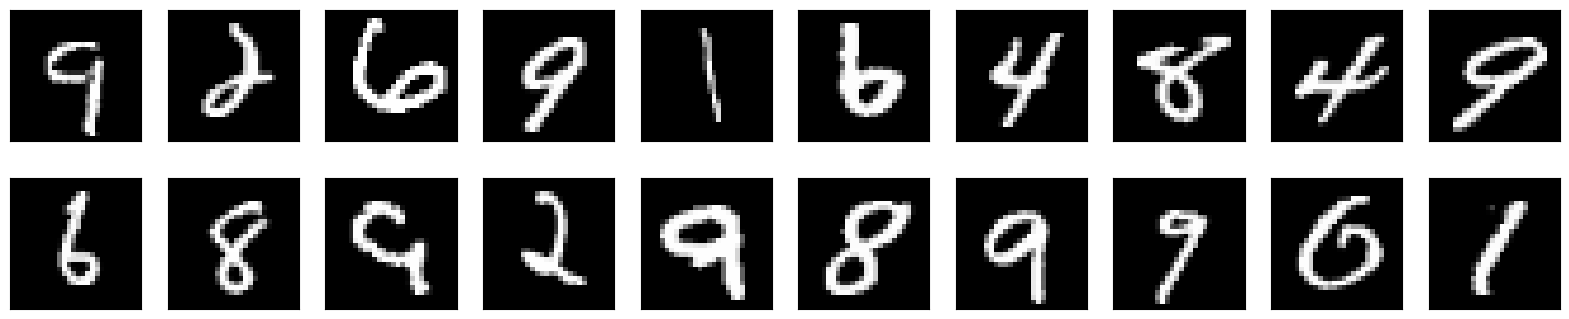

Training IntermediateAutoencoder with barlow_twins loss...
Epoch [1/50], Train Loss: 0.7272
Epoch [2/50], Train Loss: 0.3089
Epoch [3/50], Train Loss: 0.2742
Epoch [4/50], Train Loss: 0.2615
Epoch [5/50], Train Loss: 0.2538
Epoch [6/50], Train Loss: 0.2537
Epoch [7/50], Train Loss: 0.2513
Epoch [8/50], Train Loss: 0.2397
Epoch [9/50], Train Loss: 0.2370
Epoch [10/50], Train Loss: 0.2344
Epoch [11/50], Train Loss: 0.2325
Epoch [12/50], Train Loss: 0.2298
Epoch [13/50], Train Loss: 0.2284
Epoch [14/50], Train Loss: 0.2260
Epoch [15/50], Train Loss: 0.2245
Epoch [16/50], Train Loss: 0.2219
Epoch [17/50], Train Loss: 0.2208
Epoch [18/50], Train Loss: 0.2190
Epoch [19/50], Train Loss: 0.2180
Epoch [20/50], Train Loss: 0.2159
Epoch [21/50], Train Loss: 0.2104
Epoch [22/50], Train Loss: 0.2093
Epoch [23/50], Train Loss: 0.2081
Epoch [24/50], Train Loss: 0.2087
Epoch [25/50], Train Loss: 0.2081
Epoch [26/50], Train Loss: 0.2079
Epoch [27/50], Train Loss: 0.2078
Epoch [28/50], Train Loss: 0.207

In [9]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_type": "autoencoder",  # Options: "autoencoder", "vae", "dae"
    "model_name": "IntermediateAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder", "BasicVAE", "ImprovedVAE", "FlexibleVAE", "ImprovedFlexibleVAE", "DenoisingAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "loss_type": "barlow_twins",  # Options: "mse", "vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"
    "noise_factor": 0.1,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 50,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_best": True,  # Whether to save the best model
    "save_path": "best_model.pth",  # Path to save the best model
    "beta": 1.0,  # Weight for KL divergence (VAE only)
    "alpha": 0.5,  # Weight for contrastive or triplet loss
    "fraction": 1.0,  # Fraction of the dataset to use
    "projection_dim": None,  # Optional projection head dimension for VAEs
    "strong_architecture": False,  # Whether to use a deeper architecture for DenoisingAutoencoder
    "input_shape": (1, 28, 28),  # Input shape for FlexibleVAE and ImprovedFlexibleVAE
    "patience": 8,
    "min_delta": 0.001,
    "triplet_data": False,
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load Combined MNIST Dataset (Train + Test)
# mnist_loader = data_utils.load_mnist_data(fraction=config["fraction"], batch_size=config["batch_size"], shuffle=True)

# # Inspect Combined Dataset
# for batch in mnist_loader:
#     images, labels = batch
#     print("Batch Shape:", images.shape, labels.shape)
#     break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
    "BasicVAE": encoder_models.BasicVAE,
    "ImprovedVAE": encoder_models.ImprovedVAE,
    "FlexibleVAE": encoder_models.FlexibleVAE,
    "ImprovedFlexibleVAE": encoder_models.ImprovedFlexibleVAE,
    "DenoisingAutoencoder": encoder_models.DenoisingAutoencoder,
}

# Initialize model with appropriate arguments
if config["model_name"] in ["FlexibleVAE", "ImprovedFlexibleVAE"]:
    model = model_classes[config["model_name"]](
        input_shape=config["input_shape"],
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"]
    ).to(config["device"])
elif config["model_name"] == "DenoisingAutoencoder":
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"],
        strong_architecture=config["strong_architecture"]
    ).to(config["device"])
else:
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"]
    ).to(config["device"])

# Define the loss function
if config["model_type"] == "vae":
    criterion = losses.vae_loss  # Use VAE loss for VAEs
else:
    loss_functions = {
        "mse": nn.MSELoss(),  # Reconstruction loss
        "vicreg": cl_loss.VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
        "ntxent": cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
        "triplet": cl_loss.TripletLoss(margin=config["margin"]),  # Triplet loss
        "contrastive": cl_loss.contrastive_loss,  # Basic contrastive loss
        "info_nce": cl_loss.info_nce_loss,  # InfoNCE loss
        "barlow_twins": cl_loss.BarlowTwinsLoss(lambda_param=5e-3),  # Barlow Twins loss
        "byol": cl_loss.BYOLLoss(),  # BYOL loss
    }
    criterion = loss_functions[config["loss_type"]]

predictor = cl_loss.Predictor(input_dim=config["code_dim"]).to(config["device"])

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

if config["model_type"] == "autoencoder":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_autoencoder_v4(
        model=model,
        data_loader=mnist_loader,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        optimizer=optimizer,
        epochs=config["epochs"],
        device=config["device"],
        scheduler=scheduler,
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        temperature=config["temperature"],  # Pass temperature for NT-Xent, contrastive, and InfoNCE
        triplet_data=(config["loss_type"] == "triplet"),  # Enable triplet data only for triplet loss
        augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        predictor=predictor if config["loss_type"] == "byol" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "vae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_vae(
        vae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,  # VAE loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        beta=config["beta"],  # Weight for KL divergence
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "dae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_dae(
        dae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        noise_factor=config["noise_factor"],  # Noise factor for denoising
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        triplet_loss_fn=criterion if config["loss_type"] == "triplet" else None,
        ssim_func=losses.ssim if config["loss_type"] == "ssim" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Generate embeddings
embeddings, labels = data_utils.generate_embeddings(
    model=model,
    embedding_type=config["model_type"],
    data_loader=mnist_loader,
    device=config["device"],
)

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{config['model_type']}_{config['model_name']}_{config['loss_type']}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings

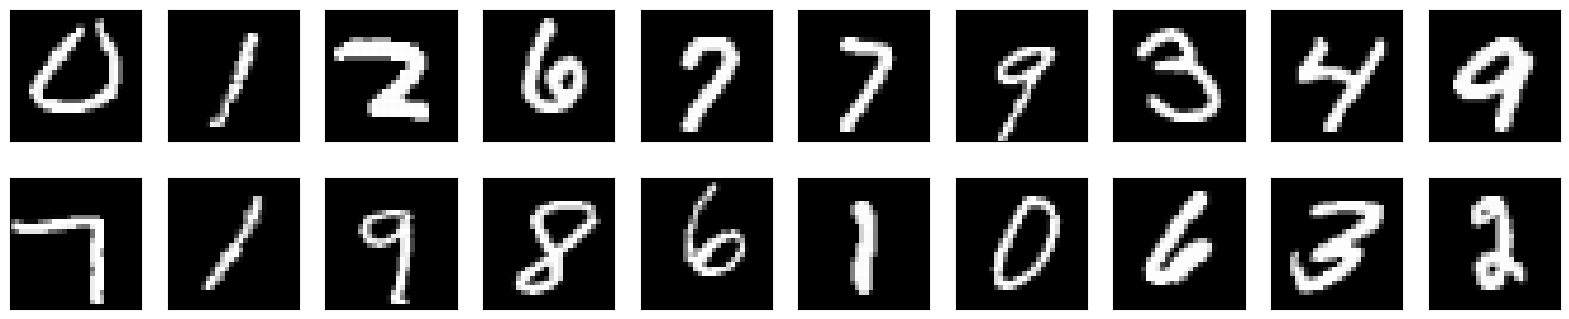

Training IntermediateAutoencoder with contrastive loss...
Epoch [1/50], Train Loss: 2.5328
Epoch [2/50], Train Loss: 2.3788
Epoch [3/50], Train Loss: 2.3559
Epoch [4/50], Train Loss: 2.3449
Epoch [5/50], Train Loss: 2.3372
Epoch [6/50], Train Loss: 2.3329
Epoch [7/50], Train Loss: 2.3292
Epoch [8/50], Train Loss: 2.3273
Epoch [9/50], Train Loss: 2.3251
Epoch [10/50], Train Loss: 2.3229
Epoch [11/50], Train Loss: 2.3217
Epoch [12/50], Train Loss: 2.3203
Epoch [13/50], Train Loss: 2.3187
Epoch [14/50], Train Loss: 2.3179
Epoch [15/50], Train Loss: 2.3167
Epoch [16/50], Train Loss: 2.3156
Epoch [17/50], Train Loss: 2.3149
Epoch [18/50], Train Loss: 2.3141
Epoch [19/50], Train Loss: 2.3130
Epoch [20/50], Train Loss: 2.3127
Epoch [21/50], Train Loss: 2.3071
Epoch [22/50], Train Loss: 2.3066
Epoch [23/50], Train Loss: 2.3061
Epoch [24/50], Train Loss: 2.3063
Epoch [25/50], Train Loss: 2.3061
Epoch [26/50], Train Loss: 2.3055
Epoch [27/50], Train Loss: 2.3057
Epoch [28/50], Train Loss: 2.3057

In [10]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_type": "autoencoder",  # Options: "autoencoder", "vae", "dae"
    "model_name": "IntermediateAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder", "BasicVAE", "ImprovedVAE", "FlexibleVAE", "ImprovedFlexibleVAE", "DenoisingAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "loss_type": "contrastive",  # Options: "mse", "vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"
    "noise_factor": 0.1,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 50,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_best": True,  # Whether to save the best model
    "save_path": "best_model.pth",  # Path to save the best model
    "beta": 1.0,  # Weight for KL divergence (VAE only)
    "alpha": 0.5,  # Weight for contrastive or triplet loss
    "fraction": 1.0,  # Fraction of the dataset to use
    "projection_dim": None,  # Optional projection head dimension for VAEs
    "strong_architecture": False,  # Whether to use a deeper architecture for DenoisingAutoencoder
    "input_shape": (1, 28, 28),  # Input shape for FlexibleVAE and ImprovedFlexibleVAE
    "patience": 8,
    "min_delta": 0.001,
    "triplet_data": False,
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load Combined MNIST Dataset (Train + Test)
# mnist_loader = data_utils.load_mnist_data(fraction=config["fraction"], batch_size=config["batch_size"], shuffle=True)

# # Inspect Combined Dataset
# for batch in mnist_loader:
#     images, labels = batch
#     print("Batch Shape:", images.shape, labels.shape)
#     break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
    "BasicVAE": encoder_models.BasicVAE,
    "ImprovedVAE": encoder_models.ImprovedVAE,
    "FlexibleVAE": encoder_models.FlexibleVAE,
    "ImprovedFlexibleVAE": encoder_models.ImprovedFlexibleVAE,
    "DenoisingAutoencoder": encoder_models.DenoisingAutoencoder,
}

# Initialize model with appropriate arguments
if config["model_name"] in ["FlexibleVAE", "ImprovedFlexibleVAE"]:
    model = model_classes[config["model_name"]](
        input_shape=config["input_shape"],
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"]
    ).to(config["device"])
elif config["model_name"] == "DenoisingAutoencoder":
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"],
        strong_architecture=config["strong_architecture"]
    ).to(config["device"])
else:
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"]
    ).to(config["device"])

# Define the loss function
if config["model_type"] == "vae":
    criterion = losses.vae_loss  # Use VAE loss for VAEs
else:
    loss_functions = {
        "mse": nn.MSELoss(),  # Reconstruction loss
        "vicreg": cl_loss.VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
        "ntxent": cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
        "triplet": cl_loss.TripletLoss(margin=config["margin"]),  # Triplet loss
        "contrastive": cl_loss.contrastive_loss,  # Basic contrastive loss
        "info_nce": cl_loss.info_nce_loss,  # InfoNCE loss
        "barlow_twins": cl_loss.BarlowTwinsLoss(lambda_param=5e-3),  # Barlow Twins loss
        "byol": cl_loss.BYOLLoss(),  # BYOL loss
    }
    criterion = loss_functions[config["loss_type"]]

predictor = cl_loss.Predictor(input_dim=config["code_dim"]).to(config["device"])

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

if config["model_type"] == "autoencoder":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_autoencoder_v4(
        model=model,
        data_loader=mnist_loader,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        optimizer=optimizer,
        epochs=config["epochs"],
        device=config["device"],
        scheduler=scheduler,
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        temperature=config["temperature"],  # Pass temperature for NT-Xent, contrastive, and InfoNCE
        triplet_data=(config["loss_type"] == "triplet"),  # Enable triplet data only for triplet loss
        augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        predictor=predictor if config["loss_type"] == "byol" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "vae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_vae(
        vae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,  # VAE loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        beta=config["beta"],  # Weight for KL divergence
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "dae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_dae(
        dae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        noise_factor=config["noise_factor"],  # Noise factor for denoising
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        triplet_loss_fn=criterion if config["loss_type"] == "triplet" else None,
        ssim_func=losses.ssim if config["loss_type"] == "ssim" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Generate embeddings
embeddings, labels = data_utils.generate_embeddings(
    model=model,
    embedding_type=config["model_type"],
    data_loader=mnist_loader,
    device=config["device"],
)

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{config['model_type']}_{config['model_name']}_{config['loss_type']}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings

In [ ]:
from src.embeddings.encoder_models import (
    process_matrix_factorization,
    apply_sift,
    process_feature_extraction,
    NormalizingFlowModel,
    train_nf_model,
)

# ------------------------------
# Configuration Dictionary
# ------------------------------

config = {
    # Save format and paths
    "save_format": "pt",  # Options: "pt" (PyTorch) or "npy" (NumPy)
    "base_dir": "./saved_embeddings",
    "embeddings_dir": "./saved_embeddings/embeddings",

    # Model and loss naming
    "model_name": "matrix_factorization",
    "loss_type": "default_loss",

    # Data settings
    "n_components": 50,  # Number of components for dimensionality reduction
    "n_features": 50,  # Number of features for SIFT
    "kernel": "rbf",  # Kernel for Kernel PCA

    # Normalizing Flow settings
    "num_flows": 4,
    "num_epochs": 100,
    "learning_rate": 1e-3,
    "batch_size": 128,

    # Device (CPU/GPU)
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# Ensure valid save format
if config["save_format"] not in ["pt", "npy"]:
    print(f"Invalid save format: {config['save_format']}. Defaulting to 'pt'.")
    config["save_format"] = "pt"

# Create directories if they don't exist
os.makedirs(config["base_dir"], exist_ok=True)
os.makedirs(config["embeddings_dir"], exist_ok=True)

# ------------------------------
# Helper Function to Save Embeddings
# ------------------------------

def save_embeddings(embeddings, labels, file_path, save_format):
    """Save embeddings and labels in the specified format."""
    if save_format == "pt":
        torch.save({"embeddings": embeddings, "labels": labels}, file_path)
    elif save_format == "npy":
        np.save(file_path, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    else:
        raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 1: Load Data
# ------------------------------

# Extract flattened images and labels
sampled_x, sampled_y = mnist_loader.dataset.tensors[0].numpy(), mnist_loader.dataset.tensors[1].numpy()

# ------------------------------
# Step 2: Matrix Factorization
# ------------------------------

print("Processing matrix factorization models (PCA, SVD, NMF)...")
factorized_embeddings, factorized_labels = process_matrix_factorization(
    sampled_x, sampled_y, n_components=config["n_components"]
)

for method, embeddings in factorized_embeddings.items():
    embedding_subdir = f"matrix_factorization_{method}"
    embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_{method}_embeddings.{config['save_format']}")
    save_embeddings(embeddings, factorized_labels, embedding_file, config["save_format"])
    print(f"{method} embeddings saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

# ------------------------------
# Step 3: SIFT Features
# ------------------------------

print("Processing SIFT features...")
sift_features = apply_sift(sampled_x, n_features=config["n_features"])
sift_labels = torch.tensor(sampled_y, dtype=torch.long)

embedding_subdir = "sift_features"
embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_sift_embeddings.{config['save_format']}")
save_embeddings(sift_features, sift_labels, embedding_file, config["save_format"])
print(f"SIFT embeddings saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

# ------------------------------
# Step 4: Kernel PCA
# ------------------------------

print("Processing Kernel PCA...")
kernel_pca_features, kernel_pca_labels = process_feature_extraction(
    sampled_x, sampled_y, n_features=config["n_features"], kernel=config["kernel"], n_components=config["n_components"]
)

for method, embeddings in kernel_pca_features.items():
    embedding_subdir = f"kernel_pca_{method}"
    embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_kernel_pca_{method}_embeddings.{config['save_format']}")
    save_embeddings(embeddings, kernel_pca_labels, embedding_file, config["save_format"])
    print(f"{method} Kernel PCA embeddings saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

# ------------------------------
# Step 5: Normalizing Flow
# ------------------------------

print("Processing Normalizing Flow...")
for method, embeddings in factorized_embeddings.items():
    # Initialize and train Normalizing Flow model
    input_dim = embeddings.size(1)
    nf_model = NormalizingFlowModel(input_dim=input_dim, num_flows=config["num_flows"]).to(config["device"])
    trained_nf_model = train_nf_model(
        nf_model, embeddings, num_epochs=config["num_epochs"], lr=config["learning_rate"], batch_size=config["batch_size"]
    )

    # Refine embeddings
    with torch.no_grad():
        refined_embeddings, _ = trained_nf_model(embeddings)

        embedding_subdir = f"normalizing_flow_{method}"
        embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
        os.makedirs(embedding_dir, exist_ok=True)

        embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_normalizing_flow_{method}_refined_embeddings.{config['save_format']}")
        save_embeddings(refined_embeddings, factorized_labels, embedding_file, config["save_format"])
        print(f"{method} refined embeddings (Normalizing Flow) saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

print("Feature extraction and normalizing flow processing complete!")

Processing matrix factorization models (PCA, SVD, NMF)...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_PCA/matrix_factorization_default_loss_PCA_embeddings.pt
SVD embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_SVD/matrix_factorization_default_loss_SVD_embeddings.pt
NMF embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_NMF/matrix_factorization_default_loss_NMF_embeddings.pt
Processing SIFT features...
SIFT embeddings saved in PyTorch format: ./saved_embeddings/embeddings/sift_features/matrix_factorization_default_loss_sift_embeddings.pt
Processing Kernel PCA...
SIFT Kernel PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/kernel_pca_SIFT/matrix_factorization_default_loss_kernel_pca_SIFT_embeddings.pt
Kernel PCA Kernel PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/kernel_pca_Kernel PCA/matrix_factorization_default_loss_kernel_pca_Kernel PCA_embeddings.pt
Processing Normalizing Flo

Epoch 1/100: 100%|██████████| 6/6 [00:00<00:00, 36.57it/s, loss=2.07e+6]


Epoch 1/100, Loss: 3358708.4375


Epoch 2/100: 100%|██████████| 6/6 [00:00<00:00, 107.73it/s, loss=7.67e+5]


Epoch 2/100, Loss: 2421180.1562


Epoch 3/100: 100%|██████████| 6/6 [00:00<00:00, 81.05it/s, loss=1.28e+6]


Epoch 3/100, Loss: 1847919.9583


Epoch 4/100: 100%|██████████| 6/6 [00:00<00:00, 69.78it/s, loss=6.37e+5]


Epoch 4/100, Loss: 1471227.9167


Epoch 5/100: 100%|██████████| 6/6 [00:00<00:00, 84.62it/s, loss=4.63e+5]


Epoch 5/100, Loss: 1251132.6458


Epoch 6/100: 100%|██████████| 6/6 [00:00<00:00, 85.21it/s, loss=4.12e+5]


Epoch 6/100, Loss: 1145675.3698


Epoch 7/100: 100%|██████████| 6/6 [00:00<00:00, 81.63it/s, loss=3.62e+5]


Epoch 7/100, Loss: 964567.2292


Epoch 8/100: 100%|██████████| 6/6 [00:00<00:00, 83.97it/s, loss=3.18e+5]


Epoch 8/100, Loss: 852232.8125


Epoch 9/100: 100%|██████████| 6/6 [00:00<00:00, 107.51it/s, loss=5.24e+5]


Epoch 9/100, Loss: 773914.8542


Epoch 10/100: 100%|██████████| 6/6 [00:00<00:00, 106.12it/s, loss=3.87e+5]


Epoch 10/100, Loss: 681183.7708


Epoch 11/100: 100%|██████████| 6/6 [00:00<00:00, 108.85it/s, loss=2.09e+5]


Epoch 11/100, Loss: 597496.1615


Epoch 12/100: 100%|██████████| 6/6 [00:00<00:00, 97.27it/s, loss=4.3e+5]


Epoch 12/100, Loss: 529674.9219


Epoch 13/100: 100%|██████████| 6/6 [00:00<00:00, 90.65it/s, loss=1.75e+5]


Epoch 13/100, Loss: 479913.4297


Epoch 14/100: 100%|██████████| 6/6 [00:00<00:00, 101.71it/s, loss=3.19e+5]


Epoch 14/100, Loss: 429102.1875


Epoch 15/100: 100%|██████████| 6/6 [00:00<00:00, 98.08it/s, loss=1.53e+5]


Epoch 15/100, Loss: 394330.2578


Epoch 16/100: 100%|██████████| 6/6 [00:00<00:00, 86.20it/s, loss=1.97e+5]


Epoch 16/100, Loss: 362477.1484


Epoch 17/100: 100%|██████████| 6/6 [00:00<00:00, 86.77it/s, loss=1.46e+5]


Epoch 17/100, Loss: 340135.8021


Epoch 18/100: 100%|██████████| 6/6 [00:00<00:00, 70.91it/s, loss=1.18e+5]


Epoch 18/100, Loss: 314237.1810


Epoch 19/100: 100%|██████████| 6/6 [00:00<00:00, 81.17it/s, loss=1.55e+5]


Epoch 19/100, Loss: 291413.4427


Epoch 20/100: 100%|██████████| 6/6 [00:00<00:00, 79.56it/s, loss=1.56e+5]


Epoch 20/100, Loss: 290707.3542


Epoch 21/100: 100%|██████████| 6/6 [00:00<00:00, 79.78it/s, loss=1.09e+5]


Epoch 21/100, Loss: 278803.9284


Epoch 22/100: 100%|██████████| 6/6 [00:00<00:00, 74.38it/s, loss=1.77e+5]


Epoch 22/100, Loss: 238892.1484


Epoch 23/100: 100%|██████████| 6/6 [00:00<00:00, 80.61it/s, loss=1.1e+5]


Epoch 23/100, Loss: 222431.6576


Epoch 24/100: 100%|██████████| 6/6 [00:00<00:00, 88.80it/s, loss=6.85e+4]


Epoch 24/100, Loss: 207214.7018


Epoch 25/100: 100%|██████████| 6/6 [00:00<00:00, 82.08it/s, loss=1.12e+5]


Epoch 25/100, Loss: 199458.5755


Epoch 26/100: 100%|██████████| 6/6 [00:00<00:00, 76.88it/s, loss=8.64e+4]


Epoch 26/100, Loss: 186315.3945


Epoch 27/100: 100%|██████████| 6/6 [00:00<00:00, 87.14it/s, loss=8.48e+4]


Epoch 27/100, Loss: 178262.0560


Epoch 28/100: 100%|██████████| 6/6 [00:00<00:00, 95.33it/s, loss=84156.0]


Epoch 28/100, Loss: 167682.5859


Epoch 29/100: 100%|██████████| 6/6 [00:00<00:00, 88.11it/s, loss=6.83e+4]


Epoch 29/100, Loss: 160388.3893


Epoch 30/100: 100%|██████████| 6/6 [00:00<00:00, 79.89it/s, loss=6.82e+4]


Epoch 30/100, Loss: 152936.5846


Epoch 31/100: 100%|██████████| 6/6 [00:00<00:00, 72.68it/s, loss=6.38e+4]


Epoch 31/100, Loss: 145889.3184


Epoch 32/100: 100%|██████████| 6/6 [00:00<00:00, 82.38it/s, loss=7.9e+4]


Epoch 32/100, Loss: 139763.9167


Epoch 33/100: 100%|██████████| 6/6 [00:00<00:00, 68.67it/s, loss=5.41e+4]


Epoch 33/100, Loss: 133955.5905


Epoch 34/100: 100%|██████████| 6/6 [00:00<00:00, 78.86it/s, loss=8.38e+4]


Epoch 34/100, Loss: 128101.5221


Epoch 35/100: 100%|██████████| 6/6 [00:00<00:00, 71.97it/s, loss=4.97e+4]


Epoch 35/100, Loss: 122939.9733


Epoch 36/100: 100%|██████████| 6/6 [00:00<00:00, 83.57it/s, loss=6.21e+4]


Epoch 36/100, Loss: 118031.4922


Epoch 37/100: 100%|██████████| 6/6 [00:00<00:00, 86.68it/s, loss=5.16e+4]


Epoch 37/100, Loss: 113217.8691


Epoch 38/100: 100%|██████████| 6/6 [00:00<00:00, 77.16it/s, loss=5.4e+4]


Epoch 38/100, Loss: 108768.2956


Epoch 39/100: 100%|██████████| 6/6 [00:00<00:00, 102.11it/s, loss=4.5e+4]


Epoch 39/100, Loss: 104747.7949


Epoch 40/100: 100%|██████████| 6/6 [00:00<00:00, 88.08it/s, loss=6.76e+4]


Epoch 40/100, Loss: 100538.6341


Epoch 41/100: 100%|██████████| 6/6 [00:00<00:00, 78.83it/s, loss=4.37e+4]


Epoch 41/100, Loss: 96904.3444


Epoch 42/100: 100%|██████████| 6/6 [00:00<00:00, 96.72it/s, loss=4.14e+4]


Epoch 42/100, Loss: 93436.9753


Epoch 43/100: 100%|██████████| 6/6 [00:00<00:00, 86.00it/s, loss=5.47e+4]


Epoch 43/100, Loss: 89912.4876


Epoch 44/100: 100%|██████████| 6/6 [00:00<00:00, 98.62it/s, loss=5.63e+4]


Epoch 44/100, Loss: 86996.9225


Epoch 45/100: 100%|██████████| 6/6 [00:00<00:00, 98.84it/s, loss=4.22e+4]


Epoch 45/100, Loss: 84351.9759


Epoch 46/100: 100%|██████████| 6/6 [00:00<00:00, 101.57it/s, loss=4.32e+4]


Epoch 46/100, Loss: 81205.8405


Epoch 47/100: 100%|██████████| 6/6 [00:00<00:00, 100.49it/s, loss=3.48e+4]


Epoch 47/100, Loss: 78411.0033


Epoch 48/100: 100%|██████████| 6/6 [00:00<00:00, 98.18it/s, loss=3.65e+4]


Epoch 48/100, Loss: 75849.1829


Epoch 49/100: 100%|██████████| 6/6 [00:00<00:00, 106.14it/s, loss=5.49e+4]


Epoch 49/100, Loss: 73511.2305


Epoch 50/100: 100%|██████████| 6/6 [00:00<00:00, 100.09it/s, loss=3.21e+4]


Epoch 50/100, Loss: 71467.8600


Epoch 51/100: 100%|██████████| 6/6 [00:00<00:00, 101.90it/s, loss=3.37e+4]


Epoch 51/100, Loss: 69202.5221


Epoch 52/100: 100%|██████████| 6/6 [00:00<00:00, 100.43it/s, loss=4.22e+4]


Epoch 52/100, Loss: 67169.2773


Epoch 53/100: 100%|██████████| 6/6 [00:00<00:00, 97.12it/s, loss=3.95e+4]


Epoch 53/100, Loss: 65240.4076


Epoch 54/100: 100%|██████████| 6/6 [00:00<00:00, 81.58it/s, loss=2.94e+4]


Epoch 54/100, Loss: 63348.4551


Epoch 55/100: 100%|██████████| 6/6 [00:00<00:00, 83.09it/s, loss=2.58e+4]


Epoch 55/100, Loss: 61536.6569


Epoch 56/100: 100%|██████████| 6/6 [00:00<00:00, 88.40it/s, loss=2.49e+4]


Epoch 56/100, Loss: 59762.9795


Epoch 57/100: 100%|██████████| 6/6 [00:00<00:00, 85.10it/s, loss=3.22e+4]


Epoch 57/100, Loss: 58057.9798


Epoch 58/100: 100%|██████████| 6/6 [00:00<00:00, 64.33it/s, loss=2.43e+4]


Epoch 58/100, Loss: 56409.8597


Epoch 59/100: 100%|██████████| 6/6 [00:00<00:00, 83.43it/s, loss=3.08e+4]


Epoch 59/100, Loss: 54758.1706


Epoch 60/100: 100%|██████████| 6/6 [00:00<00:00, 85.89it/s, loss=3.06e+4]


Epoch 60/100, Loss: 53477.2435


Epoch 61/100: 100%|██████████| 6/6 [00:00<00:00, 83.39it/s, loss=2.8e+4]


Epoch 61/100, Loss: 51979.7142


Epoch 62/100: 100%|██████████| 6/6 [00:00<00:00, 68.17it/s, loss=2.42e+4]


Epoch 62/100, Loss: 50955.9232


Epoch 63/100: 100%|██████████| 6/6 [00:00<00:00, 83.03it/s, loss=2.02e+4]


Epoch 63/100, Loss: 50059.9313


Epoch 64/100: 100%|██████████| 6/6 [00:00<00:00, 76.10it/s, loss=2.37e+4]


Epoch 64/100, Loss: 48892.0033


Epoch 65/100: 100%|██████████| 6/6 [00:00<00:00, 91.37it/s, loss=1.91e+4]


Epoch 65/100, Loss: 47641.3688


Epoch 66/100: 100%|██████████| 6/6 [00:00<00:00, 75.20it/s, loss=2.54e+4]


Epoch 66/100, Loss: 46573.9515


Epoch 67/100: 100%|██████████| 6/6 [00:00<00:00, 77.14it/s, loss=2.66e+4]


Epoch 67/100, Loss: 45430.9251


Epoch 68/100: 100%|██████████| 6/6 [00:00<00:00, 37.63it/s, loss=2.1e+4]


Epoch 68/100, Loss: 44408.0306


Epoch 69/100: 100%|██████████| 6/6 [00:00<00:00, 39.11it/s, loss=2.15e+4]


Epoch 69/100, Loss: 43342.6315


Epoch 70/100: 100%|██████████| 6/6 [00:00<00:00, 33.69it/s, loss=2.1e+4]


Epoch 70/100, Loss: 42381.0215


Epoch 71/100: 100%|██████████| 6/6 [00:00<00:00, 69.35it/s, loss=2.09e+4]


Epoch 71/100, Loss: 41489.6631


Epoch 72/100: 100%|██████████| 6/6 [00:00<00:00, 74.82it/s, loss=2.54e+4]


Epoch 72/100, Loss: 40590.6426


Epoch 73/100: 100%|██████████| 6/6 [00:00<00:00, 74.55it/s, loss=2e+4]


Epoch 73/100, Loss: 39775.6618


Epoch 74/100: 100%|██████████| 6/6 [00:00<00:00, 42.54it/s, loss=1.95e+4]


Epoch 74/100, Loss: 38931.5667


Epoch 75/100: 100%|██████████| 6/6 [00:00<00:00, 62.28it/s, loss=2.07e+4]


Epoch 75/100, Loss: 38064.4867


Epoch 76/100: 100%|██████████| 6/6 [00:00<00:00, 80.66it/s, loss=1.72e+4]


Epoch 76/100, Loss: 37216.5501


Epoch 77/100: 100%|██████████| 6/6 [00:00<00:00, 67.33it/s, loss=1.55e+4]


Epoch 77/100, Loss: 36429.3504


Epoch 78/100: 100%|██████████| 6/6 [00:00<00:00, 65.46it/s, loss=1.9e+4]


Epoch 78/100, Loss: 35686.0915


Epoch 79/100: 100%|██████████| 6/6 [00:00<00:00, 66.23it/s, loss=1.75e+4]


Epoch 79/100, Loss: 34992.1217


Epoch 80/100: 100%|██████████| 6/6 [00:00<00:00, 74.96it/s, loss=1.41e+4]


Epoch 80/100, Loss: 34316.6235


Epoch 81/100: 100%|██████████| 6/6 [00:00<00:00, 86.02it/s, loss=2.1e+4]


Epoch 81/100, Loss: 33686.7214


Epoch 82/100: 100%|██████████| 6/6 [00:00<00:00, 61.38it/s, loss=1.78e+4]


Epoch 82/100, Loss: 33068.7715


Epoch 83/100: 100%|██████████| 6/6 [00:00<00:00, 20.25it/s, loss=1.6e+4]


Epoch 83/100, Loss: 32472.2646


Epoch 84/100: 100%|██████████| 6/6 [00:00<00:00, 26.08it/s, loss=1.47e+4]


Epoch 84/100, Loss: 31874.8514


Epoch 85/100: 100%|██████████| 6/6 [00:00<00:00, 44.20it/s, loss=1.74e+4]


Epoch 85/100, Loss: 31250.9049


Epoch 86/100: 100%|██████████| 6/6 [00:00<00:00, 56.69it/s, loss=1.4e+4]


Epoch 86/100, Loss: 30678.5666


Epoch 87/100: 100%|██████████| 6/6 [00:00<00:00, 49.20it/s, loss=1.55e+4]


Epoch 87/100, Loss: 30157.6507


Epoch 88/100: 100%|██████████| 6/6 [00:00<00:00, 62.85it/s, loss=1.66e+4]


Epoch 88/100, Loss: 29618.8926


Epoch 89/100: 100%|██████████| 6/6 [00:00<00:00, 48.00it/s, loss=1.54e+4]


Epoch 89/100, Loss: 29256.7609


Epoch 90/100: 100%|██████████| 6/6 [00:00<00:00, 74.49it/s, loss=1.47e+4]


Epoch 90/100, Loss: 28672.9494


Epoch 91/100: 100%|██████████| 6/6 [00:00<00:00, 52.99it/s, loss=1.65e+4]


Epoch 91/100, Loss: 28188.0859


Epoch 92/100: 100%|██████████| 6/6 [00:00<00:00, 63.30it/s, loss=1.39e+4]


Epoch 92/100, Loss: 27735.6774


Epoch 93/100: 100%|██████████| 6/6 [00:00<00:00, 79.98it/s, loss=1.47e+4]


Epoch 93/100, Loss: 27292.6880


Epoch 94/100: 100%|██████████| 6/6 [00:00<00:00, 53.58it/s, loss=1.34e+4]


Epoch 94/100, Loss: 26823.1232


Epoch 95/100: 100%|██████████| 6/6 [00:00<00:00, 52.85it/s, loss=1.24e+4]


Epoch 95/100, Loss: 26418.6688


Epoch 96/100: 100%|██████████| 6/6 [00:00<00:00, 78.69it/s, loss=1.34e+4]


Epoch 96/100, Loss: 26004.0822


Epoch 97/100: 100%|██████████| 6/6 [00:00<00:00, 83.10it/s, loss=1.19e+4]


Epoch 97/100, Loss: 25667.7428


Epoch 98/100: 100%|██████████| 6/6 [00:00<00:00, 93.44it/s, loss=1e+4]


Epoch 98/100, Loss: 25269.3530


Epoch 99/100: 100%|██████████| 6/6 [00:00<00:00, 92.91it/s, loss=1.22e+4]


Epoch 99/100, Loss: 24884.7345


Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 93.22it/s, loss=1.12e+4]


Epoch 100/100, Loss: 24520.1574
PCA refined embeddings (Normalizing Flow) saved in PyTorch format: ./saved_embeddings/embeddings/normalizing_flow_PCA/matrix_factorization_default_loss_normalizing_flow_PCA_refined_embeddings.pt


Epoch 1/100: 100%|██████████| 6/6 [00:00<00:00, 62.82it/s, loss=2.08e+6]


Epoch 1/100, Loss: 3476399.4792


Epoch 2/100: 100%|██████████| 6/6 [00:00<00:00, 73.00it/s, loss=1.56e+6]


Epoch 2/100, Loss: 2232664.2917


Epoch 3/100: 100%|██████████| 6/6 [00:00<00:00, 83.20it/s, loss=6.75e+5]


Epoch 3/100, Loss: 1731757.9583


Epoch 4/100: 100%|██████████| 6/6 [00:00<00:00, 77.65it/s, loss=5.32e+5]


Epoch 4/100, Loss: 1374345.9583


Epoch 5/100: 100%|██████████| 6/6 [00:00<00:00, 73.23it/s, loss=6.47e+5]


Epoch 5/100, Loss: 1154157.3229


Epoch 6/100: 100%|██████████| 6/6 [00:00<00:00, 52.86it/s, loss=4.06e+5]


Epoch 6/100, Loss: 1002222.1562


Epoch 7/100: 100%|██████████| 6/6 [00:00<00:00, 70.09it/s, loss=3.98e+5]


Epoch 7/100, Loss: 871659.7708


Epoch 8/100: 100%|██████████| 6/6 [00:00<00:00, 96.65it/s, loss=7.52e+5]


Epoch 8/100, Loss: 752746.9271


Epoch 9/100: 100%|██████████| 6/6 [00:00<00:00, 101.07it/s, loss=3.16e+5]


Epoch 9/100, Loss: 660082.9740


Epoch 10/100: 100%|██████████| 6/6 [00:00<00:00, 93.56it/s, loss=4e+5]


Epoch 10/100, Loss: 570510.6094


Epoch 11/100: 100%|██████████| 6/6 [00:00<00:00, 59.93it/s, loss=1.84e+5]


Epoch 11/100, Loss: 513269.3698


Epoch 12/100: 100%|██████████| 6/6 [00:00<00:00, 60.39it/s, loss=1.77e+5]


Epoch 12/100, Loss: 475452.8255


Epoch 13/100: 100%|██████████| 6/6 [00:00<00:00, 55.10it/s, loss=3.09e+5]


Epoch 13/100, Loss: 447217.4948


Epoch 14/100: 100%|██████████| 6/6 [00:00<00:00, 67.40it/s, loss=2.05e+5]


Epoch 14/100, Loss: 410697.2370


Epoch 15/100: 100%|██████████| 6/6 [00:00<00:00, 76.08it/s, loss=1.29e+5]


Epoch 15/100, Loss: 380160.4831


Epoch 16/100: 100%|██████████| 6/6 [00:00<00:00, 92.95it/s, loss=1.76e+5]


Epoch 16/100, Loss: 353773.5755


Epoch 17/100: 100%|██████████| 6/6 [00:00<00:00, 96.36it/s, loss=1.02e+5]


Epoch 17/100, Loss: 326704.5495


Epoch 18/100: 100%|██████████| 6/6 [00:00<00:00, 67.90it/s, loss=1.3e+5]


Epoch 18/100, Loss: 304544.5716


Epoch 19/100: 100%|██████████| 6/6 [00:00<00:00, 67.49it/s, loss=1.16e+5]


Epoch 19/100, Loss: 284459.7096


Epoch 20/100: 100%|██████████| 6/6 [00:00<00:00, 66.10it/s, loss=2.43e+5]


Epoch 20/100, Loss: 266055.6562


Epoch 21/100: 100%|██████████| 6/6 [00:00<00:00, 54.80it/s, loss=1.03e+5]


Epoch 21/100, Loss: 254308.7018


Epoch 22/100: 100%|██████████| 6/6 [00:00<00:00, 48.67it/s, loss=1.84e+5]


Epoch 22/100, Loss: 239262.2630


Epoch 23/100: 100%|██████████| 6/6 [00:00<00:00, 59.76it/s, loss=1.24e+5]


Epoch 23/100, Loss: 224476.8216


Epoch 24/100: 100%|██████████| 6/6 [00:00<00:00, 79.46it/s, loss=1.3e+5]


Epoch 24/100, Loss: 211794.5508


Epoch 25/100: 100%|██████████| 6/6 [00:00<00:00, 50.80it/s, loss=1.08e+5]


Epoch 25/100, Loss: 201029.0560


Epoch 26/100: 100%|██████████| 6/6 [00:00<00:00, 56.51it/s, loss=1.66e+5]


Epoch 26/100, Loss: 190888.8880


Epoch 27/100: 100%|██████████| 6/6 [00:00<00:00, 61.48it/s, loss=8.63e+4]


Epoch 27/100, Loss: 180271.5052


Epoch 28/100: 100%|██████████| 6/6 [00:00<00:00, 55.47it/s, loss=7.32e+4]


Epoch 28/100, Loss: 169998.5768


Epoch 29/100: 100%|██████████| 6/6 [00:00<00:00, 63.53it/s, loss=7.59e+4]


Epoch 29/100, Loss: 161238.2878


Epoch 30/100: 100%|██████████| 6/6 [00:00<00:00, 80.84it/s, loss=7.11e+4]


Epoch 30/100, Loss: 152895.3880


Epoch 31/100: 100%|██████████| 6/6 [00:00<00:00, 66.66it/s, loss=6.26e+4]


Epoch 31/100, Loss: 146677.0345


Epoch 32/100: 100%|██████████| 6/6 [00:00<00:00, 72.11it/s, loss=5.86e+4]


Epoch 32/100, Loss: 140104.4850


Epoch 33/100: 100%|██████████| 6/6 [00:00<00:00, 68.64it/s, loss=6.66e+4]


Epoch 33/100, Loss: 133945.3633


Epoch 34/100: 100%|██████████| 6/6 [00:00<00:00, 74.95it/s, loss=8.75e+4]


Epoch 34/100, Loss: 128261.6693


Epoch 35/100: 100%|██████████| 6/6 [00:00<00:00, 66.55it/s, loss=5.83e+4]


Epoch 35/100, Loss: 123280.9766


Epoch 36/100: 100%|██████████| 6/6 [00:00<00:00, 73.08it/s, loss=5.8e+4]


Epoch 36/100, Loss: 118371.5436


Epoch 37/100: 100%|██████████| 6/6 [00:00<00:00, 68.43it/s, loss=5.43e+4]


Epoch 37/100, Loss: 112770.4167


Epoch 38/100: 100%|██████████| 6/6 [00:00<00:00, 84.23it/s, loss=5.61e+4]


Epoch 38/100, Loss: 107955.6016


Epoch 39/100: 100%|██████████| 6/6 [00:00<00:00, 72.73it/s, loss=6.32e+4]


Epoch 39/100, Loss: 104104.2760


Epoch 40/100: 100%|██████████| 6/6 [00:00<00:00, 80.99it/s, loss=6e+4]


Epoch 40/100, Loss: 100195.2259


Epoch 41/100: 100%|██████████| 6/6 [00:00<00:00, 69.22it/s, loss=3.73e+4]


Epoch 41/100, Loss: 96786.6764


Epoch 42/100: 100%|██████████| 6/6 [00:00<00:00, 59.82it/s, loss=4.32e+4]


Epoch 42/100, Loss: 93491.1556


Epoch 43/100: 100%|██████████| 6/6 [00:00<00:00, 52.13it/s, loss=4.7e+4]


Epoch 43/100, Loss: 90280.1823


Epoch 44/100: 100%|██████████| 6/6 [00:00<00:00, 68.61it/s, loss=3.57e+4]


Epoch 44/100, Loss: 87283.3919


Epoch 45/100: 100%|██████████| 6/6 [00:00<00:00, 51.36it/s, loss=4.86e+4]


Epoch 45/100, Loss: 84214.1432


Epoch 46/100: 100%|██████████| 6/6 [00:00<00:00, 45.16it/s, loss=4.24e+4]


Epoch 46/100, Loss: 81449.0169


Epoch 47/100: 100%|██████████| 6/6 [00:00<00:00, 53.82it/s, loss=4.4e+4]


Epoch 47/100, Loss: 78686.7493


Epoch 48/100: 100%|██████████| 6/6 [00:00<00:00, 49.13it/s, loss=3.66e+4]


Epoch 48/100, Loss: 76305.7148


Epoch 49/100: 100%|██████████| 6/6 [00:00<00:00, 45.37it/s, loss=4.12e+4]


Epoch 49/100, Loss: 74161.8496


Epoch 50/100: 100%|██████████| 6/6 [00:00<00:00, 62.79it/s, loss=2.79e+4]


Epoch 50/100, Loss: 71662.7679


Epoch 51/100: 100%|██████████| 6/6 [00:00<00:00, 61.12it/s, loss=3.88e+4]


Epoch 51/100, Loss: 69514.7181


Epoch 52/100: 100%|██████████| 6/6 [00:00<00:00, 62.31it/s, loss=3.6e+4]


Epoch 52/100, Loss: 67427.9486


Epoch 53/100: 100%|██████████| 6/6 [00:00<00:00, 56.26it/s, loss=3.16e+4]


Epoch 53/100, Loss: 65497.0153


Epoch 54/100: 100%|██████████| 6/6 [00:00<00:00, 56.25it/s, loss=3.66e+4]


Epoch 54/100, Loss: 63725.0111


Epoch 55/100: 100%|██████████| 6/6 [00:00<00:00, 55.93it/s, loss=2.57e+4]


Epoch 55/100, Loss: 61889.7406


Epoch 56/100: 100%|██████████| 6/6 [00:00<00:00, 59.47it/s, loss=2.9e+4]


Epoch 56/100, Loss: 59982.8893


Epoch 57/100: 100%|██████████| 6/6 [00:00<00:00, 75.87it/s, loss=2.84e+4]


Epoch 57/100, Loss: 58352.9840


Epoch 58/100: 100%|██████████| 6/6 [00:00<00:00, 71.96it/s, loss=2.72e+4]


Epoch 58/100, Loss: 56761.4736


Epoch 59/100: 100%|██████████| 6/6 [00:00<00:00, 69.44it/s, loss=2.9e+4]


Epoch 59/100, Loss: 55969.0863


Epoch 60/100: 100%|██████████| 6/6 [00:00<00:00, 62.60it/s, loss=3.19e+4]


Epoch 60/100, Loss: 53836.5290


Epoch 61/100: 100%|██████████| 6/6 [00:00<00:00, 68.14it/s, loss=2.57e+4]


Epoch 61/100, Loss: 52827.3542


Epoch 62/100: 100%|██████████| 6/6 [00:00<00:00, 87.05it/s, loss=2.97e+4]


Epoch 62/100, Loss: 51918.7848


Epoch 63/100: 100%|██████████| 6/6 [00:00<00:00, 95.57it/s, loss=2.6e+4]


Epoch 63/100, Loss: 50376.6755


Epoch 64/100: 100%|██████████| 6/6 [00:00<00:00, 94.71it/s, loss=2.39e+4]


Epoch 64/100, Loss: 49123.5387


Epoch 65/100: 100%|██████████| 6/6 [00:00<00:00, 88.39it/s, loss=2.58e+4]


Epoch 65/100, Loss: 48050.8206


Epoch 66/100: 100%|██████████| 6/6 [00:00<00:00, 90.02it/s, loss=2.41e+4]


Epoch 66/100, Loss: 47204.7093


Epoch 67/100: 100%|██████████| 6/6 [00:00<00:00, 79.96it/s, loss=2.05e+4]


Epoch 67/100, Loss: 46150.4261


Epoch 68/100: 100%|██████████| 6/6 [00:00<00:00, 98.69it/s, loss=1.93e+4]


Epoch 68/100, Loss: 44750.4255


Epoch 69/100: 100%|██████████| 6/6 [00:00<00:00, 92.57it/s, loss=2.01e+4]


Epoch 69/100, Loss: 43776.3197


Epoch 70/100: 100%|██████████| 6/6 [00:00<00:00, 90.99it/s, loss=2.4e+4]


Epoch 70/100, Loss: 42728.7539


Epoch 71/100: 100%|██████████| 6/6 [00:00<00:00, 92.06it/s, loss=2.15e+4]


Epoch 71/100, Loss: 41675.0814


Epoch 72/100: 100%|██████████| 6/6 [00:00<00:00, 86.01it/s, loss=2.63e+4]


Epoch 72/100, Loss: 40755.0560


Epoch 73/100: 100%|██████████| 6/6 [00:00<00:00, 84.84it/s, loss=2.17e+4]


Epoch 73/100, Loss: 39786.0166


Epoch 74/100: 100%|██████████| 6/6 [00:00<00:00, 79.13it/s, loss=2.39e+4]


Epoch 74/100, Loss: 38890.6956


Epoch 75/100: 100%|██████████| 6/6 [00:00<00:00, 71.25it/s, loss=2.21e+4]


Epoch 75/100, Loss: 38174.7100


Epoch 76/100: 100%|██████████| 6/6 [00:00<00:00, 77.14it/s, loss=1.82e+4]


Epoch 76/100, Loss: 37380.4066


Epoch 77/100: 100%|██████████| 6/6 [00:00<00:00, 76.36it/s, loss=1.71e+4]


Epoch 77/100, Loss: 36571.8333


Epoch 78/100: 100%|██████████| 6/6 [00:00<00:00, 82.04it/s, loss=2.16e+4]


Epoch 78/100, Loss: 35875.1862


Epoch 79/100: 100%|██████████| 6/6 [00:00<00:00, 84.06it/s, loss=1.8e+4]


Epoch 79/100, Loss: 35155.3327


Epoch 80/100: 100%|██████████| 6/6 [00:00<00:00, 80.75it/s, loss=1.57e+4]


Epoch 80/100, Loss: 34465.4357


Epoch 81/100: 100%|██████████| 6/6 [00:00<00:00, 71.48it/s, loss=1.96e+4]


Epoch 81/100, Loss: 33816.9616


Epoch 82/100: 100%|██████████| 6/6 [00:00<00:00, 77.71it/s, loss=1.55e+4]


Epoch 82/100, Loss: 33184.0052


Epoch 83/100: 100%|██████████| 6/6 [00:00<00:00, 71.50it/s, loss=1.84e+4]


Epoch 83/100, Loss: 32639.7604


Epoch 84/100: 100%|██████████| 6/6 [00:00<00:00, 77.26it/s, loss=1.56e+4]


Epoch 84/100, Loss: 31944.7549


Epoch 85/100: 100%|██████████| 6/6 [00:00<00:00, 83.83it/s, loss=1.5e+4]


Epoch 85/100, Loss: 31447.3758


Epoch 86/100: 100%|██████████| 6/6 [00:00<00:00, 66.06it/s, loss=1.2e+4]


Epoch 86/100, Loss: 30878.4017


Epoch 87/100: 100%|██████████| 6/6 [00:00<00:00, 81.37it/s, loss=1.42e+4]


Epoch 87/100, Loss: 30201.3438


Epoch 88/100: 100%|██████████| 6/6 [00:00<00:00, 68.89it/s, loss=1.68e+4]


Epoch 88/100, Loss: 29612.4339


Epoch 89/100: 100%|██████████| 6/6 [00:00<00:00, 78.99it/s, loss=1.2e+4]


Epoch 89/100, Loss: 29501.9725


Epoch 90/100: 100%|██████████| 6/6 [00:00<00:00, 84.50it/s, loss=1.59e+4]


Epoch 90/100, Loss: 28635.2629


Epoch 91/100: 100%|██████████| 6/6 [00:00<00:00, 80.83it/s, loss=1.37e+4]


Epoch 91/100, Loss: 28175.1416


Epoch 92/100: 100%|██████████| 6/6 [00:00<00:00, 90.08it/s, loss=1.4e+4]


Epoch 92/100, Loss: 27737.5150


Epoch 93/100: 100%|██████████| 6/6 [00:00<00:00, 80.30it/s, loss=1.64e+4]


Epoch 93/100, Loss: 27284.9798


Epoch 94/100: 100%|██████████| 6/6 [00:00<00:00, 83.94it/s, loss=1.7e+4]


Epoch 94/100, Loss: 26764.5384


Epoch 95/100: 100%|██████████| 6/6 [00:00<00:00, 88.07it/s, loss=1.33e+4]


Epoch 95/100, Loss: 26326.0921


Epoch 96/100: 100%|██████████| 6/6 [00:00<00:00, 92.48it/s, loss=1.38e+4]


Epoch 96/100, Loss: 25885.9212


Epoch 97/100: 100%|██████████| 6/6 [00:00<00:00, 91.90it/s, loss=1.31e+4]


Epoch 97/100, Loss: 25453.7109


Epoch 98/100: 100%|██████████| 6/6 [00:00<00:00, 71.13it/s, loss=1.25e+4]


Epoch 98/100, Loss: 25096.5645


Epoch 99/100: 100%|██████████| 6/6 [00:00<00:00, 69.99it/s, loss=1.27e+4]


Epoch 99/100, Loss: 24671.2078


Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 83.35it/s, loss=1.07e+4]


Epoch 100/100, Loss: 24279.7354
SVD refined embeddings (Normalizing Flow) saved in PyTorch format: ./saved_embeddings/embeddings/normalizing_flow_SVD/matrix_factorization_default_loss_normalizing_flow_SVD_refined_embeddings.pt


Epoch 1/100: 100%|██████████| 6/6 [00:00<00:00, 73.14it/s, loss=2.79e+3]


Epoch 1/100, Loss: 5481.5284


Epoch 2/100: 100%|██████████| 6/6 [00:00<00:00, 64.04it/s, loss=2.77e+3]


Epoch 2/100, Loss: 5404.8086


Epoch 3/100: 100%|██████████| 6/6 [00:00<00:00, 58.94it/s, loss=2.76e+3]


Epoch 3/100, Loss: 5382.3698


Epoch 4/100: 100%|██████████| 6/6 [00:00<00:00, 63.56it/s, loss=2.76e+3]


Epoch 4/100, Loss: 5372.2974


Epoch 5/100: 100%|██████████| 6/6 [00:00<00:00, 83.17it/s, loss=2.75e+3]


Epoch 5/100, Loss: 5366.1206


Epoch 6/100: 100%|██████████| 6/6 [00:00<00:00, 68.75it/s, loss=2.75e+3]


Epoch 6/100, Loss: 5361.5289


Epoch 7/100: 100%|██████████| 6/6 [00:00<00:00, 77.90it/s, loss=2.75e+3]


Epoch 7/100, Loss: 5357.6661


Epoch 8/100: 100%|██████████| 6/6 [00:00<00:00, 80.13it/s, loss=2.74e+3]


Epoch 8/100, Loss: 5353.7866


Epoch 9/100: 100%|██████████| 6/6 [00:00<00:00, 71.88it/s, loss=2.74e+3]


Epoch 9/100, Loss: 5349.8460


Epoch 10/100: 100%|██████████| 6/6 [00:00<00:00, 87.67it/s, loss=2.74e+3]


Epoch 10/100, Loss: 5346.0431


Epoch 11/100: 100%|██████████| 6/6 [00:00<00:00, 87.27it/s, loss=2.73e+3]


Epoch 11/100, Loss: 5342.1610


Epoch 12/100: 100%|██████████| 6/6 [00:00<00:00, 95.36it/s, loss=2.73e+3]


Epoch 12/100, Loss: 5338.1427


Epoch 13/100: 100%|██████████| 6/6 [00:00<00:00, 94.98it/s, loss=2.72e+3]


Epoch 13/100, Loss: 5333.9820


Epoch 14/100: 100%|██████████| 6/6 [00:00<00:00, 87.08it/s, loss=2.72e+3]


Epoch 14/100, Loss: 5329.7205


Epoch 15/100: 100%|██████████| 6/6 [00:00<00:00, 71.42it/s, loss=2.71e+3]


Epoch 15/100, Loss: 5325.4141


Epoch 16/100: 100%|██████████| 6/6 [00:00<00:00, 80.59it/s, loss=2.71e+3]


Epoch 16/100, Loss: 5320.9227


Epoch 17/100: 100%|██████████| 6/6 [00:00<00:00, 85.12it/s, loss=2.7e+3]


Epoch 17/100, Loss: 5316.5645


Epoch 18/100: 100%|██████████| 6/6 [00:00<00:00, 101.20it/s, loss=2.7e+3]


Epoch 18/100, Loss: 5312.2836


Epoch 19/100: 100%|██████████| 6/6 [00:00<00:00, 98.18it/s, loss=2.69e+3]


Epoch 19/100, Loss: 5308.1126


Epoch 20/100: 100%|██████████| 6/6 [00:00<00:00, 69.22it/s, loss=2.69e+3]


Epoch 20/100, Loss: 5304.1874


Epoch 21/100: 100%|██████████| 6/6 [00:00<00:00, 69.24it/s, loss=2.69e+3]


Epoch 21/100, Loss: 5300.5734


Epoch 22/100: 100%|██████████| 6/6 [00:00<00:00, 58.74it/s, loss=2.68e+3]


Epoch 22/100, Loss: 5297.0206


Epoch 23/100: 100%|██████████| 6/6 [00:00<00:00, 68.25it/s, loss=2.68e+3]


Epoch 23/100, Loss: 5293.8883


Epoch 24/100: 100%|██████████| 6/6 [00:00<00:00, 75.82it/s, loss=2.68e+3]


Epoch 24/100, Loss: 5291.0549


Epoch 25/100: 100%|██████████| 6/6 [00:00<00:00, 68.18it/s, loss=2.68e+3]


Epoch 25/100, Loss: 5288.3103


Epoch 26/100: 100%|██████████| 6/6 [00:00<00:00, 73.99it/s, loss=2.67e+3]


Epoch 26/100, Loss: 5285.7412


Epoch 27/100: 100%|██████████| 6/6 [00:00<00:00, 63.96it/s, loss=2671.0]


Epoch 27/100, Loss: 5283.6004


Epoch 28/100: 100%|██████████| 6/6 [00:00<00:00, 74.36it/s, loss=2.67e+3]


Epoch 28/100, Loss: 5281.5013


Epoch 29/100: 100%|██████████| 6/6 [00:00<00:00, 68.22it/s, loss=2.67e+3]


Epoch 29/100, Loss: 5279.4812


Epoch 30/100: 100%|██████████| 6/6 [00:00<00:00, 72.18it/s, loss=2.66e+3]


Epoch 30/100, Loss: 5277.4419


Epoch 31/100: 100%|██████████| 6/6 [00:00<00:00, 72.50it/s, loss=2.66e+3]


Epoch 31/100, Loss: 5275.3955


Epoch 32/100: 100%|██████████| 6/6 [00:00<00:00, 68.08it/s, loss=2.66e+3]


Epoch 32/100, Loss: 5274.0279


Epoch 33/100: 100%|██████████| 6/6 [00:00<00:00, 57.03it/s, loss=2.66e+3]


Epoch 33/100, Loss: 5272.2230


Epoch 34/100: 100%|██████████| 6/6 [00:00<00:00, 74.10it/s, loss=2.66e+3]


Epoch 34/100, Loss: 5270.9952


Epoch 35/100: 100%|██████████| 6/6 [00:00<00:00, 75.47it/s, loss=2.66e+3]


Epoch 35/100, Loss: 5269.2483


Epoch 36/100: 100%|██████████| 6/6 [00:00<00:00, 78.36it/s, loss=2.66e+3]


Epoch 36/100, Loss: 5267.7466


Epoch 37/100: 100%|██████████| 6/6 [00:00<00:00, 63.77it/s, loss=2.65e+3]


Epoch 37/100, Loss: 5266.2290


Epoch 38/100: 100%|██████████| 6/6 [00:00<00:00, 62.62it/s, loss=2.65e+3]


Epoch 38/100, Loss: 5264.7682


Epoch 39/100: 100%|██████████| 6/6 [00:00<00:00, 60.70it/s, loss=2.65e+3]


Epoch 39/100, Loss: 5263.9369


Epoch 40/100: 100%|██████████| 6/6 [00:00<00:00, 72.14it/s, loss=2.65e+3]


Epoch 40/100, Loss: 5262.7376


Epoch 41/100: 100%|██████████| 6/6 [00:00<00:00, 85.72it/s, loss=2.65e+3]


Epoch 41/100, Loss: 5261.9191


Epoch 42/100: 100%|██████████| 6/6 [00:00<00:00, 99.15it/s, loss=2.65e+3]


Epoch 42/100, Loss: 5260.7370


Epoch 43/100: 100%|██████████| 6/6 [00:00<00:00, 83.84it/s, loss=2.65e+3]


Epoch 43/100, Loss: 5260.1261


Epoch 44/100: 100%|██████████| 6/6 [00:00<00:00, 92.98it/s, loss=2.65e+3]


Epoch 44/100, Loss: 5259.3719


Epoch 45/100: 100%|██████████| 6/6 [00:00<00:00, 93.36it/s, loss=2.65e+3]


Epoch 45/100, Loss: 5258.0825


Epoch 46/100: 100%|██████████| 6/6 [00:00<00:00, 82.31it/s, loss=2.65e+3]


Epoch 46/100, Loss: 5256.9305


Epoch 47/100: 100%|██████████| 6/6 [00:00<00:00, 92.17it/s, loss=2.64e+3]


Epoch 47/100, Loss: 5255.8656


Epoch 48/100: 100%|██████████| 6/6 [00:00<00:00, 93.50it/s, loss=2.64e+3]


Epoch 48/100, Loss: 5254.9724


Epoch 49/100: 100%|██████████| 6/6 [00:00<00:00, 92.43it/s, loss=2.64e+3]


Epoch 49/100, Loss: 5254.1268


Epoch 50/100: 100%|██████████| 6/6 [00:00<00:00, 73.89it/s, loss=2.64e+3]


Epoch 50/100, Loss: 5253.2002


Epoch 51/100: 100%|██████████| 6/6 [00:00<00:00, 91.22it/s, loss=2.64e+3]


Epoch 51/100, Loss: 5252.3311


Epoch 52/100: 100%|██████████| 6/6 [00:00<00:00, 94.59it/s, loss=2.64e+3]


Epoch 52/100, Loss: 5251.4462


Epoch 53/100: 100%|██████████| 6/6 [00:00<00:00, 76.94it/s, loss=2.64e+3]


Epoch 53/100, Loss: 5250.8895


Epoch 54/100: 100%|██████████| 6/6 [00:00<00:00, 78.04it/s, loss=2.64e+3]


Epoch 54/100, Loss: 5249.9297


Epoch 55/100: 100%|██████████| 6/6 [00:00<00:00, 54.49it/s, loss=2.64e+3]


Epoch 55/100, Loss: 5249.3018


Epoch 56/100: 100%|██████████| 6/6 [00:00<00:00, 60.37it/s, loss=2.64e+3]


Epoch 56/100, Loss: 5248.7972


Epoch 57/100: 100%|██████████| 6/6 [00:00<00:00, 79.02it/s, loss=2.64e+3]


Epoch 57/100, Loss: 5248.2872


Epoch 58/100: 100%|██████████| 6/6 [00:00<00:00, 77.09it/s, loss=2.64e+3]


Epoch 58/100, Loss: 5247.6230


Epoch 59/100: 100%|██████████| 6/6 [00:00<00:00, 65.58it/s, loss=2.64e+3]


Epoch 59/100, Loss: 5246.6736


Epoch 60/100: 100%|██████████| 6/6 [00:00<00:00, 78.44it/s, loss=2.64e+3]


Epoch 60/100, Loss: 5245.9157


Epoch 61/100: 100%|██████████| 6/6 [00:00<00:00, 87.90it/s, loss=2.63e+3]


Epoch 61/100, Loss: 5245.1157


Epoch 62/100: 100%|██████████| 6/6 [00:00<00:00, 80.40it/s, loss=2.63e+3]


Epoch 62/100, Loss: 5244.4133


Epoch 63/100: 100%|██████████| 6/6 [00:00<00:00, 76.92it/s, loss=2.63e+3]


Epoch 63/100, Loss: 5243.6681


Epoch 64/100: 100%|██████████| 6/6 [00:00<00:00, 82.00it/s, loss=2.63e+3]


Epoch 64/100, Loss: 5243.2593


Epoch 65/100: 100%|██████████| 6/6 [00:00<00:00, 73.81it/s, loss=2.63e+3]


Epoch 65/100, Loss: 5242.4785


Epoch 66/100: 100%|██████████| 6/6 [00:00<00:00, 80.08it/s, loss=2.63e+3]


Epoch 66/100, Loss: 5242.2761


Epoch 67/100: 100%|██████████| 6/6 [00:00<00:00, 82.22it/s, loss=2.63e+3]


Epoch 67/100, Loss: 5241.4966


Epoch 68/100: 100%|██████████| 6/6 [00:00<00:00, 81.40it/s, loss=2.63e+3]


Epoch 68/100, Loss: 5241.1039


Epoch 69/100: 100%|██████████| 6/6 [00:00<00:00, 74.35it/s, loss=2.63e+3]


Epoch 69/100, Loss: 5240.3432


Epoch 70/100: 100%|██████████| 6/6 [00:00<00:00, 52.05it/s, loss=2.63e+3]


Epoch 70/100, Loss: 5239.9497


Epoch 71/100: 100%|██████████| 6/6 [00:00<00:00, 50.46it/s, loss=2.63e+3]


Epoch 71/100, Loss: 5239.4091


Epoch 72/100: 100%|██████████| 6/6 [00:00<00:00, 83.70it/s, loss=2.63e+3]


Epoch 72/100, Loss: 5238.9976


Epoch 73/100: 100%|██████████| 6/6 [00:00<00:00, 75.53it/s, loss=2.63e+3]


Epoch 73/100, Loss: 5238.3294


Epoch 74/100: 100%|██████████| 6/6 [00:00<00:00, 71.03it/s, loss=2.63e+3]


Epoch 74/100, Loss: 5237.7444


Epoch 75/100: 100%|██████████| 6/6 [00:00<00:00, 67.13it/s, loss=2.63e+3]


Epoch 75/100, Loss: 5237.0498


Epoch 76/100: 100%|██████████| 6/6 [00:00<00:00, 68.47it/s, loss=2.63e+3]


Epoch 76/100, Loss: 5236.5045


Epoch 77/100: 100%|██████████| 6/6 [00:00<00:00, 54.81it/s, loss=2.63e+3]


Epoch 77/100, Loss: 5236.2478


Epoch 78/100: 100%|██████████| 6/6 [00:00<00:00, 51.66it/s, loss=2.63e+3]


Epoch 78/100, Loss: 5235.8320


Epoch 79/100: 100%|██████████| 6/6 [00:00<00:00, 57.70it/s, loss=2.63e+3]


Epoch 79/100, Loss: 5235.3754


Epoch 80/100: 100%|██████████| 6/6 [00:00<00:00, 73.04it/s, loss=2.63e+3]


Epoch 80/100, Loss: 5235.5533


Epoch 81/100: 100%|██████████| 6/6 [00:00<00:00, 87.32it/s, loss=2.62e+3]


Epoch 81/100, Loss: 5234.9341


Epoch 82/100: 100%|██████████| 6/6 [00:00<00:00, 67.83it/s, loss=2.62e+3]


Epoch 82/100, Loss: 5234.5599


Epoch 83/100: 100%|██████████| 6/6 [00:00<00:00, 67.34it/s, loss=2.62e+3]


Epoch 83/100, Loss: 5234.6737


Epoch 84/100: 100%|██████████| 6/6 [00:00<00:00, 68.45it/s, loss=2.62e+3]


Epoch 84/100, Loss: 5234.3649


Epoch 85/100: 100%|██████████| 6/6 [00:00<00:00, 59.59it/s, loss=2.62e+3]


Epoch 85/100, Loss: 5233.7415


Epoch 86/100: 100%|██████████| 6/6 [00:00<00:00, 58.64it/s, loss=2.62e+3]


Epoch 86/100, Loss: 5233.3593


Epoch 87/100: 100%|██████████| 6/6 [00:00<00:00, 37.66it/s, loss=2.62e+3]


Epoch 87/100, Loss: 5232.4336


Epoch 88/100: 100%|██████████| 6/6 [00:00<00:00, 82.76it/s, loss=2.62e+3]


Epoch 88/100, Loss: 5231.7578


Epoch 89/100: 100%|██████████| 6/6 [00:00<00:00, 81.42it/s, loss=2.62e+3]


Epoch 89/100, Loss: 5231.1811


Epoch 90/100: 100%|██████████| 6/6 [00:00<00:00, 88.24it/s, loss=2.62e+3]


Epoch 90/100, Loss: 5230.7364


Epoch 91/100: 100%|██████████| 6/6 [00:00<00:00, 69.60it/s, loss=2.62e+3]


Epoch 91/100, Loss: 5230.9087


Epoch 92/100: 100%|██████████| 6/6 [00:00<00:00, 86.77it/s, loss=2.62e+3]


Epoch 92/100, Loss: 5229.3865


Epoch 93/100: 100%|██████████| 6/6 [00:00<00:00, 65.01it/s, loss=2.62e+3]


Epoch 93/100, Loss: 5229.7407


Epoch 94/100: 100%|██████████| 6/6 [00:00<00:00, 90.52it/s, loss=2.62e+3]


Epoch 94/100, Loss: 5229.2914


Epoch 95/100: 100%|██████████| 6/6 [00:00<00:00, 66.63it/s, loss=2.62e+3]


Epoch 95/100, Loss: 5228.6436


Epoch 96/100: 100%|██████████| 6/6 [00:00<00:00, 46.13it/s, loss=2.62e+3]


Epoch 96/100, Loss: 5227.9370


Epoch 97/100: 100%|██████████| 6/6 [00:00<00:00, 52.48it/s, loss=2.62e+3]


Epoch 97/100, Loss: 5228.0457


Epoch 98/100: 100%|██████████| 6/6 [00:00<00:00, 47.49it/s, loss=2.62e+3]


Epoch 98/100, Loss: 5227.9027


Epoch 99/100: 100%|██████████| 6/6 [00:00<00:00, 69.27it/s, loss=2.62e+3]


Epoch 99/100, Loss: 5228.0733


Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 90.54it/s, loss=2.62e+3]


Epoch 100/100, Loss: 5228.5775
NMF refined embeddings (Normalizing Flow) saved in PyTorch format: ./saved_embeddings/embeddings/normalizing_flow_NMF/matrix_factorization_default_loss_normalizing_flow_NMF_refined_embeddings.pt
Feature extraction and normalizing flow processing complete!
